In [1]:
import matplotlib.pyplot as plt
import csv
import os
import numpy as np

import json

image_dir = '/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/ESEP/Delay Time 07102025'

json_path = os.path.join(image_dir, 'vars.json')
with open(json_path, 'r') as f: 
    vars = json.load(f)

output_dir = vars['output_dir']
n = vars['n']

{
  "NotebookApp": {
      "autosave_interval": 30000  # in ms (30 seconds)
  }
}

n


18

In [2]:
csv_path = f'/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/ESEP/Delay Time 07102025/Folder n={n}/average_values_{n}.csv'

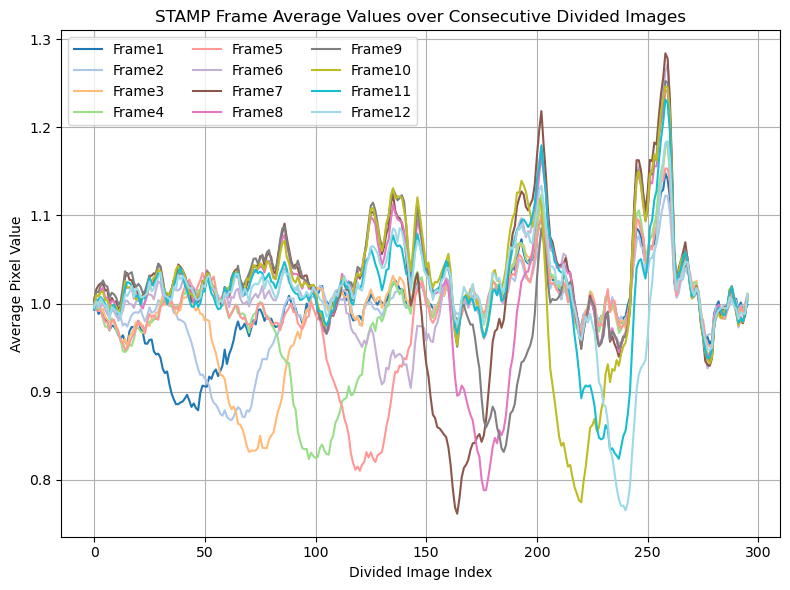

ROI1: Min Value = 0.878954 at Image Index = 47
ROI2: Min Value = 0.8675993 at Image Index = 62
ROI3: Min Value = 0.8316952 at Image Index = 70
ROI4: Min Value = 0.8236209 at Image Index = 97
ROI5: Min Value = 0.81028885 at Image Index = 120
ROI6: Min Value = 0.904346 at Image Index = 143
ROI7: Min Value = 0.7616236 at Image Index = 164
ROI8: Min Value = 0.7880783 at Image Index = 176
ROI9: Min Value = 0.8317149 at Image Index = 185
ROI10: Min Value = 0.77457166 at Image Index = 220
ROI11: Min Value = 0.8238115 at Image Index = 237
ROI12: Min Value = 0.76536477 at Image Index = 240


In [6]:
image_indices = []
roi_avgs = [[] for i in range(12)]  # List for each ROI

with open(csv_path, 'r') as f: # Load CSV
    reader = csv.reader(f)
    header = next(reader)  # Skip header
    for row in reader:
        image_indices.append(int(row[0]))
        for i in range(12):
            roi_avgs[i].append(float(row[i + 1]))


# Plot ROI averages as individual lines
plt.figure(figsize=(8, 6))
colors = plt.colormaps['tab20'].resampled(12)
for i in range(12):
    plt.plot(image_indices, roi_avgs[i], label=f'Frame{i+1}', color=colors(i))

#debugging
# plt.axhline(y=0.876, linestyle = "--")

plt.title(f'STAMP Frame Average Values over Consecutive Divided Images')
plt.xlabel('Divided Image Index')
# plt.ylim(0.8, 1.05)
plt.ylabel('Average Pixel Value')
plt.grid(True)
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig(f"Frame_Averages_{n}.png", dpi=300)
plt.show()

#finding minimum values and corresponding index
for i in range(12):
    min_val = min(roi_avgs[i])
    max_val = max(roi_avgs[i])
    min_idx = roi_avgs[i].index(min_val)
    max_idx = roi_avgs[i].index(max_val)
    image_index_at_min = image_indices[min_idx]
    image_index_at_max = image_indices[max_idx]
    print(f'ROI{i+1}: Min Value = {min_val} at Image Index = {image_index_at_min}')
    #print(f'ROI{i+1}: Max Value = {max_val} at Image Index = {image_index_at_max}')

    


In [4]:
def frame_to_time(image_number):
    #input image number of central value and output the time from zero (first frame)
    c = 3e8 #m/s
    laser_freq = 100 #Hz
    Camera_Frame_time = 0.1 #s
    Stage_speed = 0.002 #m/s - doubled because path is twice distance
    time = image_number * Camera_Frame_time * Stage_speed / c
    return time
    

## FWHM

In [5]:
# Finding FWHM
from scipy.interpolate import interp1d
from scipy.optimize import brentq

time_list = []
FWHM = {}
Central_Values = {}
for i in range(12):
    y = roi_avgs[i]
    x = image_indices

    y_min = min(y)
    x_min = x[y.index(y_min)]
    
    hm = (1 - y_min)/2 + y_min

    #debugging
    # if i == 9:
    #     print(hm)
        

    
    f_interp = interp1d(x, y, kind='linear', fill_value='extrapolate')

    # Find crossings: where (y - hm) changes sign
    crossings = []
    for j in range(len(x) - 1):
        y0, y1 = y[j], y[j + 1]
        if (y0 - hm) * (y1 - hm) < 0:  # sign change
            x0, x1 = x[j], x[j + 1]
            try:
                root = brentq(lambda x: f_interp(x) - hm, x0, x1)
                crossings.append(root)
            except ValueError:
                pass  # brentq failed; ignore

    if len(crossings) >= 2: # extrapolate two intersections (lift and right), closest to absolute minimum value.
        left_crossings = [c for c in crossings if c < x_min]
        right_crossings = [c for c in crossings if c > x_min]

        if left_crossings and right_crossings:
            
            left = max(left_crossings)
            right = min(right_crossings)
        
        width = right - left
        FWHM[f'ROI{i+1}'] = width
        print(f"ROI{i+1}: FWHM ≈ {width:.2f} (crossings at {left:.2f}, {right:.2f})")
    else:
        FWHM[f'ROI{i+1}'] = None
        print(f"ROI{i+1}: ❌ FWHM not found — fewer than 2 crossings")
   
    if i == 0: 
        shift = left + width/2 # shift first frame to zero
    Central_Values.update({f'ROI{i+1}': (left + right)/2}) 
    print(f'Centered at {Central_Values[f"ROI{i+1}"]:.2f} --> {Central_Values[f"ROI{i+1}"] - shift:.2f}')

    # converting to time domain
    time_list.append(frame_to_time(Central_Values[f"ROI{i+1}"] - shift ))

time_list 
    
    

    

    
    
  
    
    

 


ROI1: FWHM ≈ 28.77 (crossings at 29.78, 58.54)
Centered at 44.16 --> 0.00
ROI2: FWHM ≈ 29.61 (crossings at 46.09, 75.71)
Centered at 60.90 --> 16.74
ROI3: FWHM ≈ 27.28 (crossings at 58.64, 85.92)
Centered at 72.28 --> 28.12
ROI4: FWHM ≈ 29.84 (crossings at 89.01, 118.85)
Centered at 103.93 --> 59.77
ROI5: FWHM ≈ 25.73 (crossings at 109.17, 134.90)
Centered at 122.04 --> 77.88
ROI6: FWHM ≈ 18.02 (crossings at 126.85, 144.88)
Centered at 135.87 --> 91.71
ROI7: FWHM ≈ 24.81 (crossings at 152.65, 177.45)
Centered at 165.05 --> 120.89
ROI8: FWHM ≈ 18.96 (crossings at 167.83, 186.78)
Centered at 177.31 --> 133.15
ROI9: FWHM ≈ 17.40 (crossings at 174.31, 191.72)
Centered at 183.02 --> 138.86
ROI10: FWHM ≈ 21.64 (crossings at 208.11, 229.74)
Centered at 218.93 --> 174.77
ROI11: FWHM ≈ 22.89 (crossings at 219.33, 242.23)
Centered at 230.78 --> 186.62
ROI12: FWHM ≈ 13.43 (crossings at 231.03, 244.46)
Centered at 237.74 --> 193.59


[0.0,
 1.1160374945776241e-11,
 1.8745383600733287e-11,
 3.9845940474050946e-11,
 5.191741270079355e-11,
 6.113721285571475e-11,
 8.059312311324643e-11,
 8.876506022788072e-11,
 9.257101789875904e-11,
 1.1651129517258136e-10,
 1.2441492247522154e-10,
 1.2905709308429018e-10]

In [13]:
# whole time interval 
# 125.2 ps - n=45
# 129.9 ps - n=20
# 129.1 ps - n=18
# 133.4 ps - n=6, but unstable min for ROI 6 --> unreliable

csv_path = os.path.join(output_dir, f'Frame_Times_{n}.csv')

for i in range(0, 12): 
    if i == 0: #create header in csv file
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['Frame Number', 'Time (ps)']
            writer.writerow(header)
   
    # Save times to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([i+1, time_list[i] * 1e12])    
print(f'{csv_path} has been created')


/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/ESEP/Delay Time 07102025/Folder n=18/Frame_Times_18.csv has been created


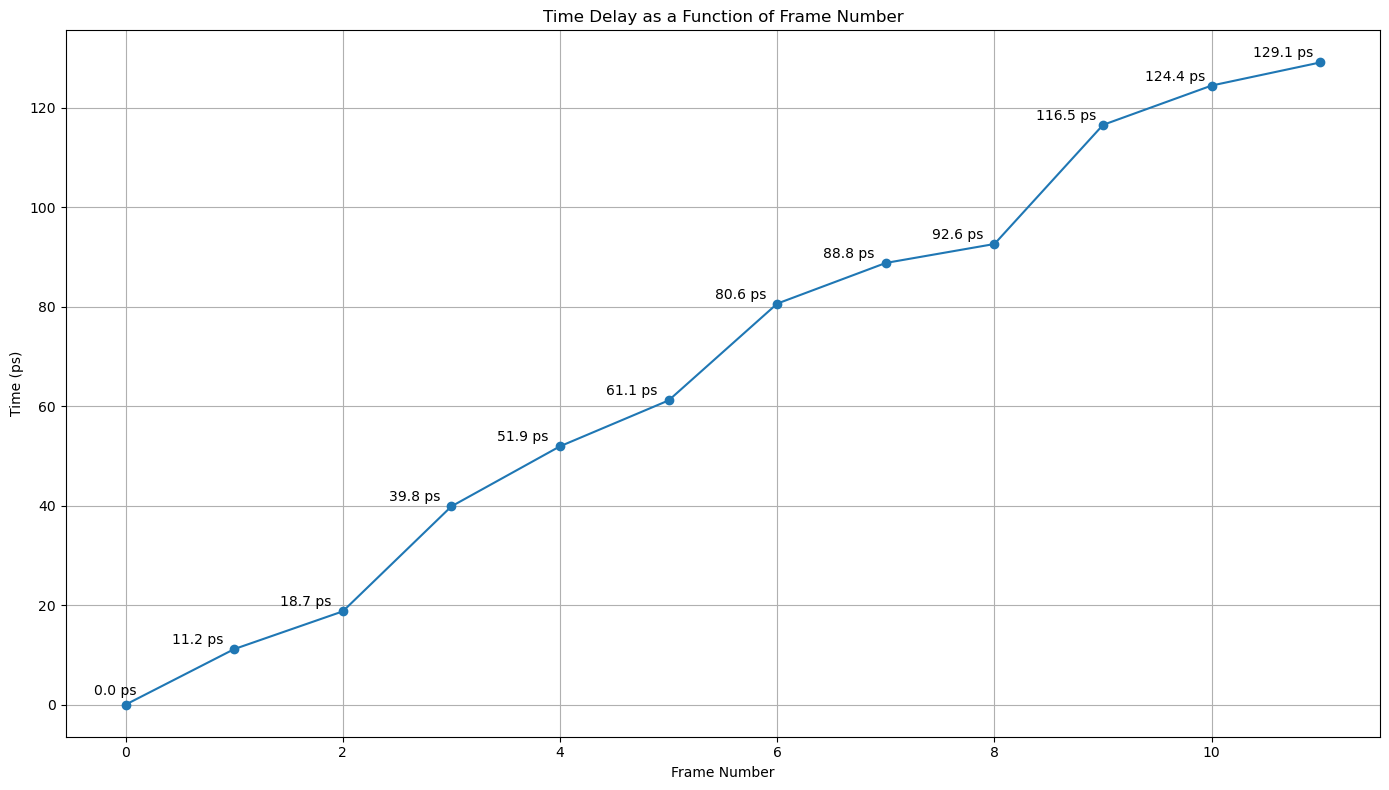

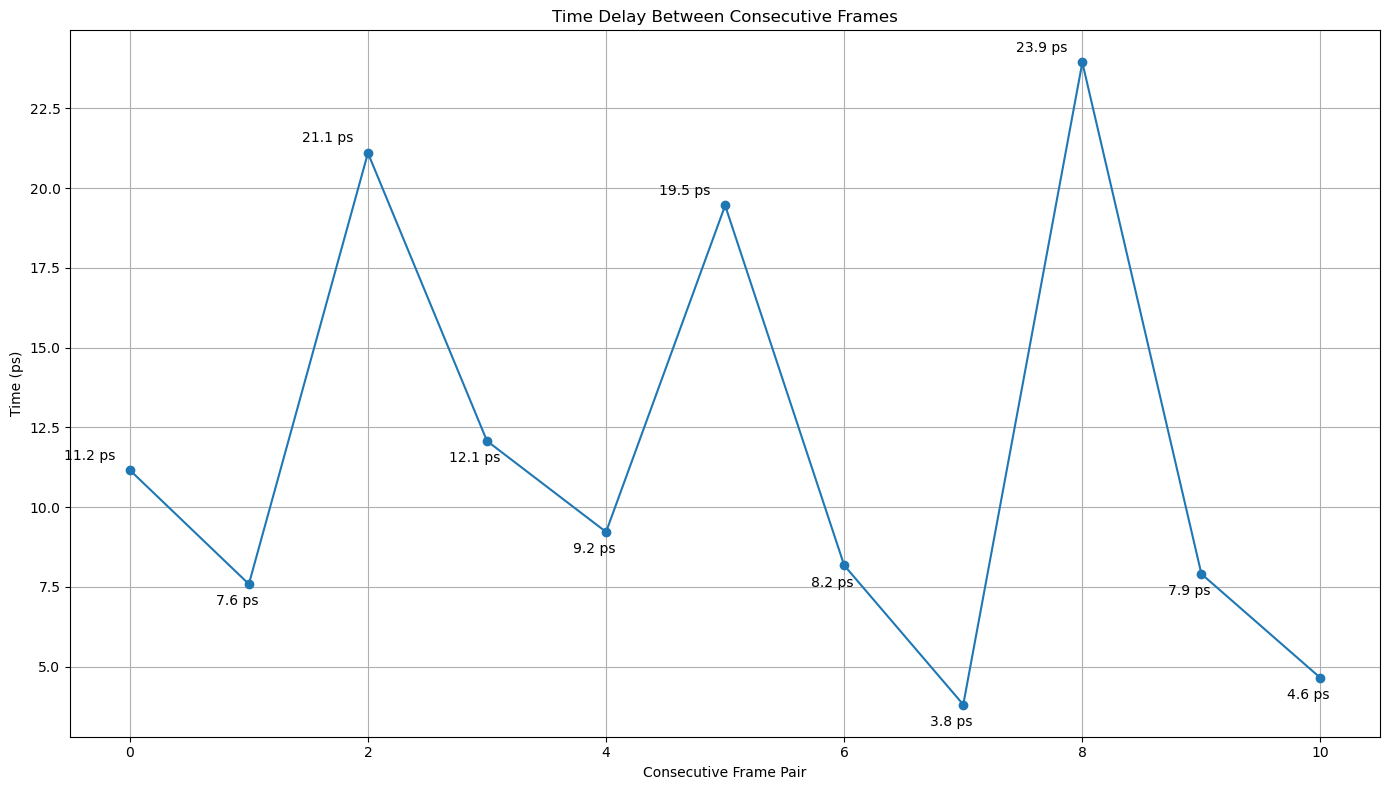

Average time interval = 11.73 ps


In [32]:
plt.figure(figsize=(14, 8))
x = np.arange(0, 12)
y = [time_list[i] * 1e12 for i in x]
plt.plot(x, y, marker = 'o')
plt.title('Time Delay as a Function of Frame Number')
plt.xlabel('Frame Number')
# plt.ylim(0.8, 1.05)
plt.ylabel('Time (ps)')
plt.grid(True)
plt.tight_layout()
for xi, yi in zip(x, y):
    if xi == 0:
        plt.text(xi - 0.1, yi + 2, f'{yi:.1f} ps', ha='center', fontsize=10)
        continue
    plt.text(xi - 0.34, yi + 1, f'{yi:.1f} ps', ha='center', fontsize=10)
plt.savefig(f"Time_Delay{n}.png", dpi=300)
plt.show()

tdiff_list = [(time_list[i+1] - time_list[i])* 1e12 for i in range(11)]

plt.figure(figsize=(14, 8))
x = np.arange(0, 12)
plt.plot(np.arange(0, 11), tdiff_list, marker = 'o')
plt.title('Time Delay Between Consecutive Frames')
plt.xlabel('Consecutive Frame Pair')
# plt.ylim(0.8, 1.05)
plt.ylabel('Time (ps)')
plt.grid(True)
plt.tight_layout()
for xi, tdiff_listi in zip(x, tdiff_list):
    if xi not in [0, 2, 5, 8]:
        plt.text(xi - 0.1, tdiff_listi - 0.67, f'{tdiff_listi:.1f} ps', ha='center', fontsize=10)
        continue
    plt.text(xi - 0.34, tdiff_listi + 0.33, f'{tdiff_listi:.1f} ps', ha='center', fontsize=10)
plt.savefig(f"Time_Diff{n}.png", dpi=300)
plt.show()

print(f'Average time interval = {sum(tdiff_list) / len(tdiff_list):.2f} ps')

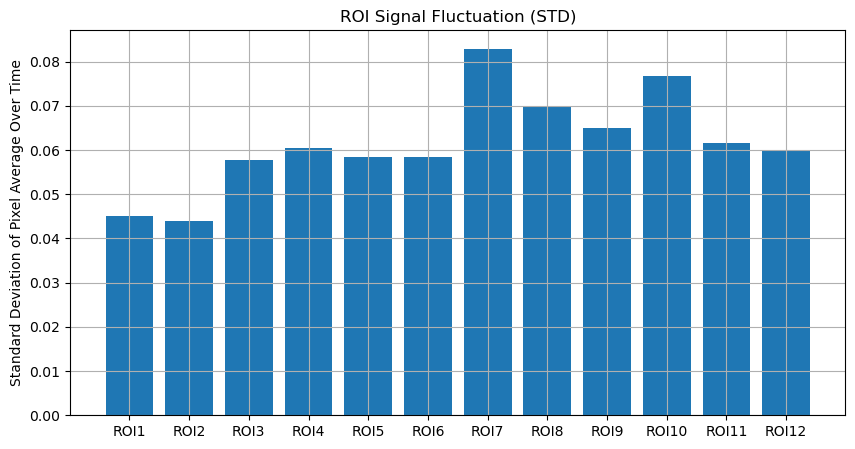

In [87]:
# Convert list of ROI averages to NumPy array: shape (num_ROIs, num_frames)
roi_array = np.array(roi_avgs)  # roi_avgs[i][j] = ROI i at frame j

# Compute standard deviation across time for each ROI
roi_std = np.std(roi_array, axis=1)

# Plot
plt.figure(figsize=(10, 5))
plt.bar([f'ROI{i+1}' for i in range(12)], roi_std)
plt.ylabel('Standard Deviation of Pixel Average Over Time')
plt.title('ROI Signal Fluctuation (STD)')
plt.grid(True)
plt.show()
